# Before you get started

## Data formatting

MINER is optimized for expression data of the form log2(TPM+1) or log2(FPKM+1). Expression data in counts format is not currently supported. If your data is in counts format, consider first transforming to log2(cpm+1) with edgeR.

If expression data is not Homo Sapiens, a reference database must be provided for mechanistic inference.

# Begin miner analysis

## Import standard dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner_py3 as miner
%matplotlib inline
plt.style.use('ggplot')

## Create directory to save output files

In [2]:
# create name for results folder where output files will be saved
resultsFolder = "miner_network_results"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load reference dictionary for mechanistic inference (skip if using default)

In [ ]:
# #provide absolute path to your .csv-format reference database
# filename = os.path.join(os.path.split(os.getcwd())[0],"data","reference_database_example.csv")
# #provide absolute path to the miner/data/network_dictionaries directory where your database will be stored
# network_dictionaries_path = os.path.join(os.path.split(os.getcwd())[0],"data","network_dictionaries")
# #name your reference database and use the extension ".pkl"
# dictionaryName = "reference_database.pkl"
# #import and save your reference database to the Python pickle format for future use
# reference_mechanistic_database = miner.fileToReferenceDictionary(filename,os.path.join(network_dictionaries_path,dictionaryName))

## Alternative clustering algorithm

In [25]:
importlib.reload(miner)
stabilized_clusters = miner.stablizedCluster(expressionData,minNumberGenes = 6,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80)

0.00 percent complete
1.8957763526945115
2.778159859407187
3.636440440045357
4.478632137462617
5.324145482567311
6.164162802591563
7.021457601606847
7.865019808579446
8.750900359642507
9.594031982744934
20.00 percent complete
10.451442096520664
10.862577532390358
11.277817344153405
11.696143802336216
12.112559891887903
12.531101562620163
12.942623951850653
13.347003240980863
13.779733916558264
14.196594736245153
40.00 percent complete
14.690906625860928
14.891308489012717
15.097408635567186
15.290241900860307
15.5129869227972
15.703745072201249
15.89852764776611
16.10208704718351
16.30266907523083
16.503103840043064
60.00 percent complete
16.748462863950724
16.865395336023326
16.98143588418245
17.08494817184138
17.19040810081839
17.29386881057405
17.41007601337337
17.514659833567375
17.6312487444961
17.735095294979565
80.00 percent complete
17.86594179583096
17.923746619189735
17.982696884870048
18.041484708044763
18.09928674986076
18.1575591915307
18.21639740053105
18.27442172800326
1

## 0. Load and pre-process data; set parameters

In [3]:
# Load expression Data
expressionFile = os.path.join(os.path.split(os.getcwd())[0],"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

completed identifier conversion.
16216 genes were converted.


Text(0.5, 0, 'Relative expression')

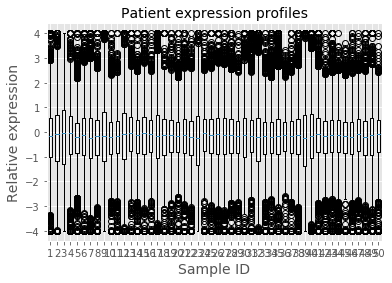

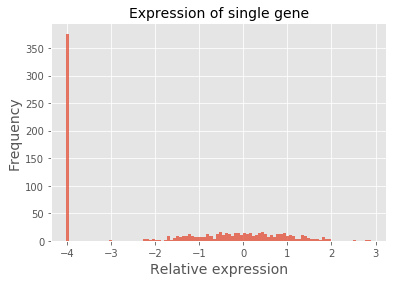

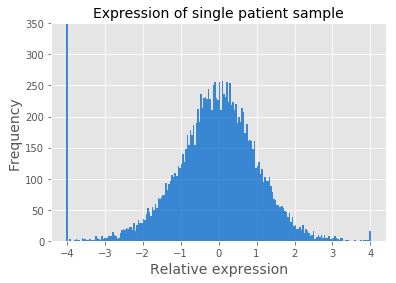

In [4]:
# Visualize pre-processed expression data
individual_expression_data = [expressionData.iloc[:,i] for i in range(50)]
_ = plt.boxplot(individual_expression_data)
plt.title("Patient expression profiles",FontSize=14)
plt.ylabel("Relative expression",FontSize=14)
plt.xlabel("Sample ID",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[0,:],bins=100,alpha=0.75)
plt.title("Expression of single gene",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[:,0],bins=200,color=[0,0.4,0.8],alpha=0.75)
plt.ylim(0,350)
plt.title("Expression of single patient sample",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)

## Set parameters

In [10]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = "tfbsdb_tf_to_genes.pkl" #default option
#mechanistic_database = reference_mechanistic_database #use if supplying your own database

# number of cores available for multiprocessing
numCores = 5

# 1. Co-expression clustering

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 10.94 minutes
Completed coexpression clustering in 12.58 minutes
Number of genes clustered: 15125
Number of unique clusters: 1161
Completed clustering module in 12.58 minutes


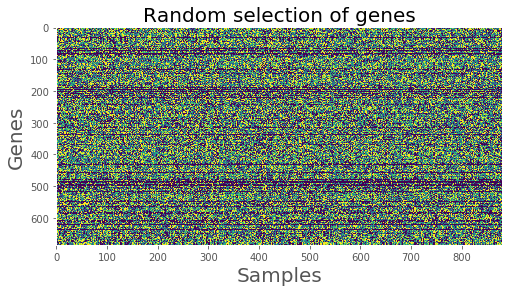

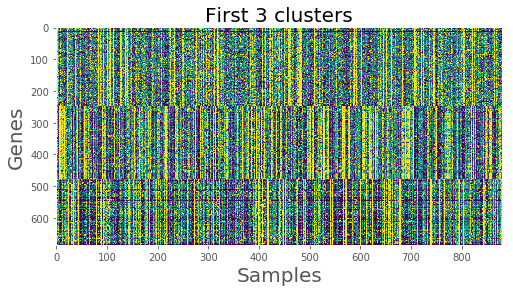

In [22]:
# Network inference may take several minutes. 
# Prompts will print at 0, 20, 40, 60, 80, and 100% complete

t1 = time.time() 
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))
t2 = time.time()
print("Completed coexpression clustering in {:.2f} minutes".format((t2-t1)/60.))

# retrieve first three clusters for visual inspection
first_clusters = np.hstack([revisedClusters[i] for i in np.arange(3).astype(str)])

# visualize background expression
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[np.random.choice(
    expressionData.index,len(first_clusters),
    replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("Random selection of genes",FontSize=20)

# visualize first 10 clusters
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("First 3 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t3 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t3-t1)/60.))

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 12.64 minutes
Completed coexpression clustering in 14.33 minutes
Number of genes clustered: 15125
Number of unique clusters: 1175
Completed clustering module in 14.33 minutes


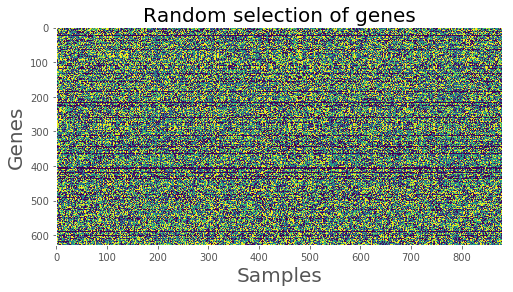

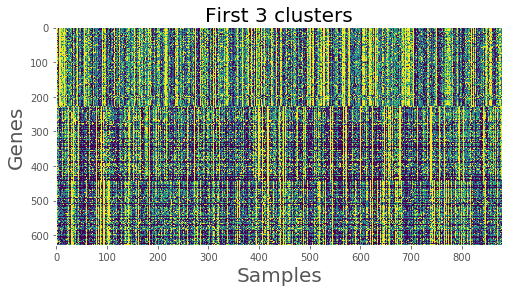

In [55]:
# Network inference may take several minutes. 
# Prompts will print at 0, 20, 40, 60, 80, and 100% complete
importlib.reload(miner)

t1 = time.time() 
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
stabilized_clusters = miner.stablizedCluster(expressionData,minNumberGenes = 6,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=1,overExpressionThreshold=80)
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(stabilized_clusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))
t2 = time.time()
print("Completed coexpression clustering in {:.2f} minutes".format((t2-t1)/60.))

# retrieve first three clusters for visual inspection
first_clusters = np.hstack([revisedClusters[i] for i in np.arange(3).astype(str)])

# visualize background expression
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[np.random.choice(
    expressionData.index,len(first_clusters),
    replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("Random selection of genes",FontSize=20)

# visualize first 10 clusters
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("First 3 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t3 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t3-t1)/60.))

In [34]:
missingState = list(set(expressionData.columns)-set(np.hstack(states)))
states.append(missingState)

In [37]:
# # Copy the current results
# revisedClusters_rs12 = revisedClusters.copy()
# regulonDf_rs12 = regulonDf.copy()
# regulonModules_rs12 = regulonModules
# eigengenes_rs12 = eigengenes.copy()
# causal_results_rs12 = causal_results.copy()
# filtered_causal_results = causal_results_stratified_aligned_correlated.copy()
# overExpressedMembersMatrix_rs12 = overExpressedMembersMatrix.copy()
# underExpressedMembersMatrix_rs12 = underExpressedMembersMatrix.copy()
# program_list_rs12 = program_list.copy()
# states_list_rs12 = states.copy()

# 2. Mechanistic inference

In [56]:
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,database=mechanistic_database)
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(resultsDirectory,"regulonDf.csv"))
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
# Get eigengenes for all modules
eigengenes = miner.getEigengenes(regulonModules,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)
#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))

t2 = time.time()
print("Completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("Inferred network with {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(regulonDf.Regulon_ID.unique()),len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))

Running mechanistic inference


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/mwall/Desktop/GitHub/miner/miner/src/miner_py3.py:1214: RuntimeWarning: invalid value encountered in greater_equal
  tfDict[tfDict_key] = tfs[np.where(np.abs(tfCorrelation)>=correlationThreshold)[0]]


Completed mechanistic inference in 5.18 minutes
Inferred network with 3121 regulons, 398 regulators, and 8612 co-regulated genes


# 3. Causal inference

In [57]:
# Load mutation matrices
common_mutations_file = os.path.join(os.path.split(os.getcwd())[0],"data","mutations","commonMutations.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)

translocations_file = os.path.join(os.path.split(os.getcwd())[0],"data","mutations","translocationsIA12.csv")
translocations = pd.read_csv(translocations_file,index_col=0,header=0)

cytogenetics_file = os.path.join(os.path.split(os.getcwd())[0],"data","mutations","cytogenetics.csv")
cytogenetics = pd.read_csv(cytogenetics_file,index_col=0,header=0)

In [58]:
# Perform causal analysis for each mutation matrix
mut_matrix = common_mutations.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

mut_matrix = translocations.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_translocations")

mut_matrix = cytogenetics.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_cytogenetics")

# compile all causal results
causal_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_results = miner.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(resultsDirectory,"completeCausalResults.csv"))
causal_results.head()

completed causal analysis in 1.60 minutes
completed causal analysis in 0.26 minutes
completed causal analysis in 0.24 minutes


,Mutation,Regulator,Regulon,MutationRegulatorEdge,-log10(p)_MutationRegulatorEdge,RegulatorRegulon_Spearman_R,RegulatorRegulon_Spearman_p-value,Regulon_stratification_t-statistic,-log10(p)_Regulon_stratification,Fraction_of_edges_correctly_aligned
302,MYH2,ENSG00000092067,R-302,-1.0,2.742852,0.566532,6.224289e-76,-2.618850,1.804924,1.0
298,MYH2,ENSG00000092067,R-298,-1.0,2.742852,0.682213,1.145198e-121,-2.459058,1.637188,1.0
161,MYH2,ENSG00000204103,R-161,-1.0,1.502768,0.663560,6.753171e-113,-2.303045,1.492838,1.0
172,MYH2,ENSG00000204103,R-172,-1.0,1.502768,0.484672,4.316804e-53,-2.488741,1.671611,1.0
168,MYH2,ENSG00000204103,R-168,-1.0,1.502768,0.289838,1.637666e-18,-2.343215,1.533601,1.0


In [59]:
# filtered causal results
causal_results_regulon_filtered = causal_results[causal_results["-log10(p)_Regulon_stratification"]>=-np.log10(0.05)]
causal_results_aligned = causal_results_regulon_filtered[causal_results_regulon_filtered.Fraction_of_edges_correctly_aligned>=0.5]
causal_results_aligned_correlated = causal_results_aligned[causal_results_aligned["RegulatorRegulon_Spearman_p-value"]<=0.05]
causal_results_stratified_aligned_correlated = causal_results_aligned_correlated[causal_results_aligned_correlated["-log10(p)_MutationRegulatorEdge"]>=-np.log10(0.05)]

# for all causal flows, 
# the regulon is differentially active w.r.t the mutation,
# the regulator is differentially active w.r.t the mutation,
# the regulator is significantly correlated to the regulon,
# and the directionality of at least half of the differentially active targets 
# downstream of the regulator are consistent with the perturbation from the mutation

causal_results_stratified_aligned_correlated.to_csv(os.path.join(resultsDirectory,"filteredCausalResults.csv"))

# 4. Network mapping

In [60]:
import importlib
importlib.reload(miner)

t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
# dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
# coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
# dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
# dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
# coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
# coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

done!
done!
Completed patient mapping in 141.83 minutes


Text(0.5, 0, 'Samples')

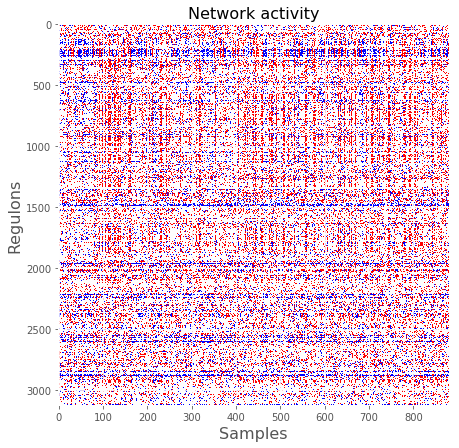

In [61]:
#visualize network activity across individual samples
plt.figure(figsize=(7,7))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)

# 5. Subtype discovery

In [62]:
importlib.reload(miner)

# Infer transcriptional states
minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
referenceMatrix = overExpressedMembersMatrix-underExpressedMembersMatrix
primaryMatrix = overExpressedMembersMatrix
primaryDictionary = overExpressedMembers
secondaryMatrix = underExpressedMembersMatrix
secondaryDictionary = underExpressedMembers

states, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = int(np.ceil(0.01*expressionData.shape[1])),restricted_index=None)
states_dictionary = {str(i):states[i] for i in range(len(states))}
miner.write_json(states_dictionary,os.path.join(resultsDirectory,"transcriptional_states.json"))

Beginning subtype inference


/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


completed subtype inference in 0.85 minutes


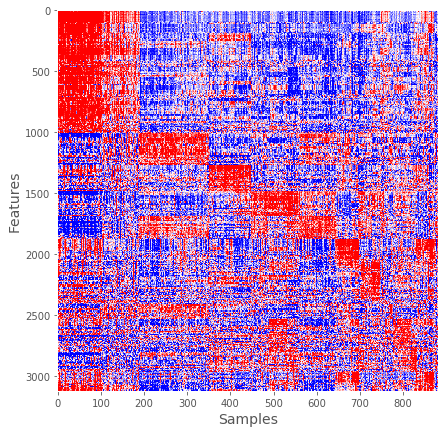

In [63]:
# Infer transcriptional programs
reference_df = eigengenes.copy()
programs, _ = miner.mosaic(dfr=eigengenes.copy(),clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
programs_dictionary = {str(i):program_list[i] for i in range(len(program_list))}
miner.write_json(programs_dictionary,os.path.join(resultsDirectory,"transcriptional_programs.json"))
mosaicDf = reference_df.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

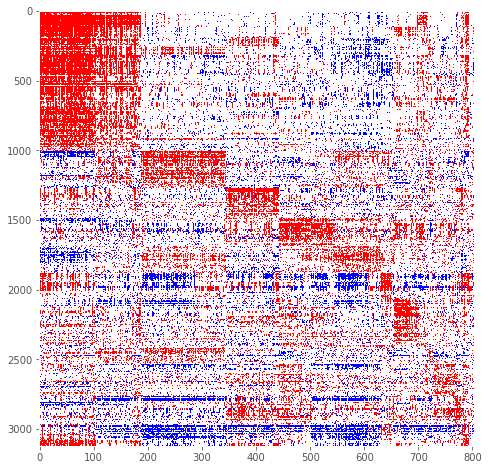

In [64]:
dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
mtrx = dfr.loc[np.hstack(program_list),np.hstack(states)]
plt.figure(figsize=(8,8))
plt.imshow(mtrx,cmap="bwr",vmin=-1,vmax=1,aspect=float(mtrx.shape[1])/float(mtrx.shape[0]))
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"mosaic_all.pdf"),bbox_inches="tight")

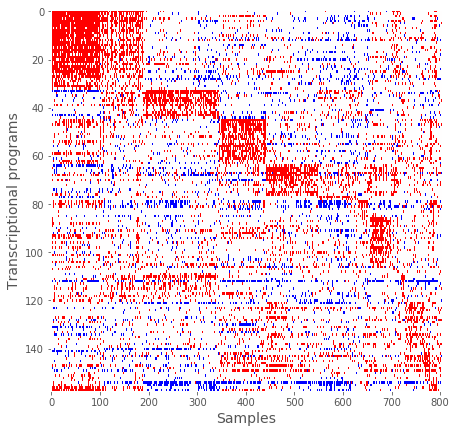

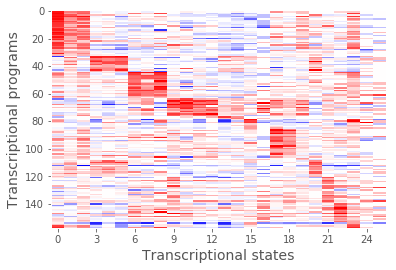

In [65]:
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=dfr.loc[np.hstack(program_list),np.hstack(states)],programs=program_list,states=states,stateThreshold=0.50,saveFile=os.path.join(resultsDirectory,"transcriptional_programs.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"programs_vs_states.pdf"),showplot=True)